<a href="https://colab.research.google.com/github/yoonkim97/pytorch-resnet-mnist/blob/master/MNISTResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import urllib
from torch.nn import functional as F

In [18]:

num_workers = 0
batch_size = 20
basepath = '.'

def set_header_for(url, filename):
    opener = urllib.request.URLopener()
    opener.addheader('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36')
    opener.retrieve(
    url, f'{basepath}/{filename}')

set_header_for('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  from ipykernel import kernelapp as app


In [0]:
class MnistResNet(ResNet):
  def __init__(self):
    super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
    self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  def forward(self, x):
    return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)

In [0]:
train_label_classes = [0, 1, 7]
test_label_classes = [0, 1, 8]
def get_same_indices(target, labels):
  label_indices = []
  for i in range (len(target)):
    for j in range (len(labels)):
      if target[i] == labels[j]:
        label_indices.append(i)
  return label_indices

In [0]:
def get_data_loaders(train_batch_size, val_batch_size):
  mnist = MNIST(download=True, train=True, root=".").train_data.float()
    
  data_transform = Compose([Resize((224, 224)),ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])

  train_dataset = MNIST(download=True, root=".", transform=data_transform, train=True)
  train_indices = get_same_indices(train_dataset.targets, train_label_classes)
  train_loader = DataLoader(dataset = train_dataset, batch_size=train_batch_size, shuffle=False, sampler=torch.utils.data.sampler.SubsetRandomSampler(train_indices))

  val_dataset = MNIST(download=False, root=".", transform=data_transform, train=False)
  val_indices = get_same_indices(val_dataset.targets, test_label_classes)
  val_loader = DataLoader(dataset = val_dataset, batch_size=val_batch_size, shuffle=False, sampler=torch.utils.data.sampler.SubsetRandomSampler(val_indices))
  return train_loader, val_loader

In [0]:
def calculate_metric(metric_fn, true_y, pred_y):
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


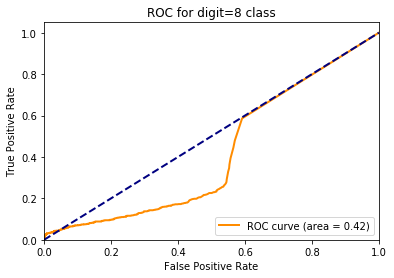

Epoch 1/5, training loss: 1.5148816430890881, validation loss: 1.793100118637085
[[ 979    0    1    0]
 [  32 1103    0    0]
 [   0    0    0    0]
 [ 956    7   11    0]]
	     precision: 0.4205
	        recall: 0.5518
	            F1: 0.4616
	      accuracy: 0.6678


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


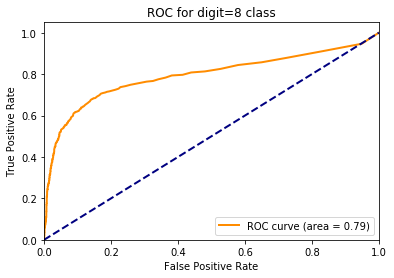

Epoch 2/5, training loss: 1.4660901169519167, validation loss: 1.7797271013259888
[[ 974    0    6    0]
 [   0 1132    3    0]
 [   0    0    0    0]
 [ 704   21  249    0]]
	     precision: 0.3873
	        recall: 0.4980
	            F1: 0.4273
	      accuracy: 0.6793


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


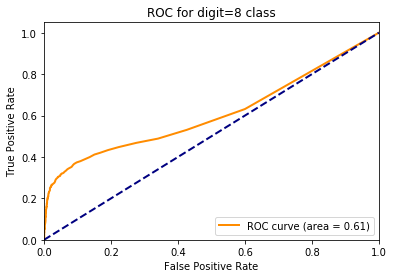

Epoch 3/5, training loss: 1.464425956880724, validation loss: 1.7747278213500977
[[ 979    0    1    0]
 [   0 1134    1    0]
 [   0    0    0    0]
 [ 925   16   33    0]]
	     precision: 0.3815
	        recall: 0.5124
	            F1: 0.4251
	      accuracy: 0.6856


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


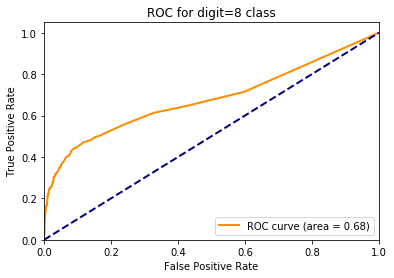

Epoch 4/5, training loss: 1.4635479643538192, validation loss: 1.765869379043579
[[ 979    0    1    0]
 [   0 1134    1    0]
 [   0    0    0    0]
 [ 826   14  134    0]]
	     precision: 0.3870
	        recall: 0.4995
	            F1: 0.4271
	      accuracy: 0.6941


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


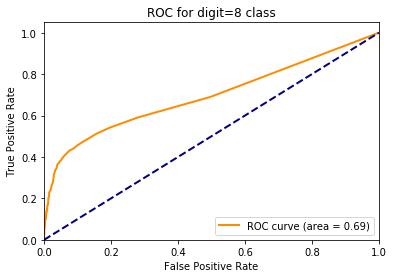

Epoch 5/5, training loss: 1.4629678001274933, validation loss: 1.7747323513031006
[[ 978    0    2    0]
 [   0 1133    2    0]
 [   0    0    0    0]
 [ 833   10  131    0]]
	     precision: 0.3832
	        recall: 0.4991
	            F1: 0.4240
	      accuracy: 0.6850
[1.5148816430890881, 1.4660901169519167, 1.464425956880724, 1.4635479643538192, 1.4629678001274933]
Training time: 206.9893980026245s


In [23]:
start_ts = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 5

model = MnistResNet().to(device)
train_loader, val_loader = get_data_loaders(256, 256)


losses = []
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters())

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(epochs):
    total_loss = 0
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        total_loss += current_loss
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    torch.cuda.empty_cache()
    
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    confusion_actuals = []
    probabilities = []
    predictions = []
    roc_actuals = []

    which_class = 8

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X)
            prediction = outputs.argmax(dim=1, keepdim=True)
            confusion_actuals.extend(y.view_as(prediction))
            roc_actuals.extend(y.view_as(prediction) == which_class)
            probabilities.extend(np.exp(outputs.cpu()[:, which_class]))  
            predictions.extend(prediction)

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1]
            
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
    confusion_actuals = [i.item() for i in confusion_actuals]
    predictions = [i.item() for i in predictions]
    roc_actuals = [i.item() for i in roc_actuals]
    class_probabilities = [i.item() for i in probabilities]


    fpr, tpr, _ = roc_curve(roc_actuals, class_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2 
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for digit=%d class' % which_class)
    plt.legend(loc="lower right")
    plt.show()
        
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print(confusion_matrix(confusion_actuals, predictions))    
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches)
print(losses)
print(f"Training time: {time.time()-start_ts}s")


In [0]:
class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self

In [0]:
class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [30]:
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(val_loader)
model_filename = 'model_with_temperature.pth'
torch.save(scaled_model.state_dict(), model_filename)
print('Temperature scaled model saved to %s', model_filename)
print('Done!')

Before temperature - NLL: 1.776, ECE: 0.465
Optimal temperature: 0.273
After temperature - NLL: 1.335, ECE: 0.117
Temperature scaled model saved to %s model_with_temperature.pth
Done!
